# OWASP Dataset Validation

This notebook validates the OWASP-compliant datasets for the MCP Security Gateway project.

**Validation checks:**
- Dataset statistics and class distributions
- Per-tool sample counts and balance
- Duplicate detection within datasets
- Overlap detection between datasets
- Attack category distribution analysis
- OWASP ratio compliance verification

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict, Counter

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Data directory
DATA_DIR = Path('../data')

print(f"Data directory: {DATA_DIR.resolve()}")

Data directory: W:\__Projects__\MCP-Security-Gateway\research\data


## 1. Load Datasets

In [2]:
def load_dataset(name: str) -> dict:
    """Load a dataset from JSON file."""
    filepath = DATA_DIR / name
    if not filepath.exists():
        print(f"WARNING: {name} not found!")
        return {}
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    print(f"Loaded {name}: {len(data)} tools")
    return data

# Load OWASP datasets
train_data = load_dataset('owasp_training_dataset.json')
val_data = load_dataset('owasp_validation_dataset.json')
test_data = load_dataset('owasp_test_dataset.json')

datasets = {
    'Training': train_data,
    'Validation': val_data,
    'Test': test_data
}

Loaded owasp_training_dataset.json: 32 tools
Loaded owasp_validation_dataset.json: 32 tools
Loaded owasp_test_dataset.json: 32 tools


## 2. Dataset Statistics Overview

In [3]:
def get_dataset_stats(data: dict) -> dict:
    """Calculate statistics for a dataset."""
    total_benign = 0
    total_attack = 0
    tools_count = len(data)
    samples_per_tool = []
    
    for tool, categories in data.items():
        benign = len(categories.get('benign', []))
        attack = len(categories.get('attack', []))
        total_benign += benign
        total_attack += attack
        samples_per_tool.append(benign + attack)
    
    total = total_benign + total_attack
    return {
        'tools': tools_count,
        'total_samples': total,
        'benign': total_benign,
        'attack': total_attack,
        'benign_pct': total_benign / total * 100 if total > 0 else 0,
        'attack_pct': total_attack / total * 100 if total > 0 else 0,
        'avg_samples_per_tool': np.mean(samples_per_tool) if samples_per_tool else 0,
        'min_samples_per_tool': min(samples_per_tool) if samples_per_tool else 0,
        'max_samples_per_tool': max(samples_per_tool) if samples_per_tool else 0,
    }

# Calculate stats for all datasets
stats_rows = []
for name, data in datasets.items():
    stats = get_dataset_stats(data)
    stats['Dataset'] = name
    stats_rows.append(stats)

stats_df = pd.DataFrame(stats_rows)
stats_df = stats_df[['Dataset', 'tools', 'total_samples', 'benign', 'attack', 'benign_pct', 'attack_pct', 
                      'avg_samples_per_tool', 'min_samples_per_tool', 'max_samples_per_tool']]
stats_df.columns = ['Dataset', 'Tools', 'Total', 'Benign', 'Attack', 'Benign %', 'Attack %', 
                    'Avg/Tool', 'Min/Tool', 'Max/Tool']

display(("### Dataset Summary"))
display(stats_df.round(1))

'### Dataset Summary'

,Dataset,Tools,Total,Benign,Attack,Benign %,Attack %,Avg/Tool,Min/Tool,Max/Tool
0,Training,32,1186,593,593,50.0,50.0,37.1,12,132
1,Validation,32,376,188,188,50.0,50.0,11.8,4,44
2,Test,32,2328,2088,240,89.7,10.3,72.8,8,251


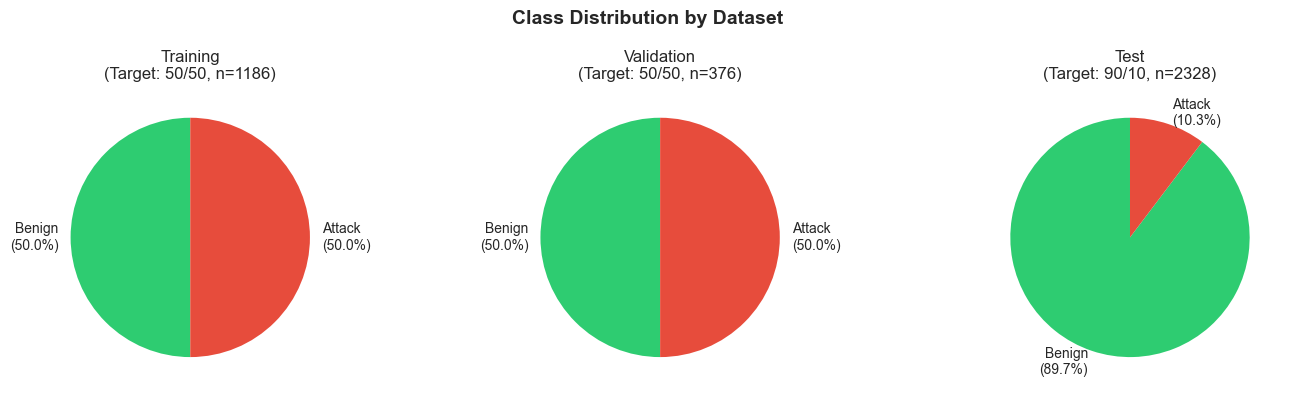

In [4]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

colors = ['#2ecc71', '#e74c3c']
targets = {'Training': '50/50', 'Validation': '50/50', 'Test': '90/10'}

for idx, (name, data) in enumerate(datasets.items()):
    stats = get_dataset_stats(data)
    sizes = [stats['benign'], stats['attack']]
    labels = [f"Benign\n({stats['benign_pct']:.1f}%)", f"Attack\n({stats['attack_pct']:.1f}%)"]
    
    axes[idx].pie(sizes, labels=labels, colors=colors, autopct='', startangle=90)
    axes[idx].set_title(f"{name}\n(Target: {targets[name]}, n={stats['total_samples']})")

plt.suptitle('Class Distribution by Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../evaluation_results/owasp_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Per-Tool Sample Analysis

In [5]:
def get_per_tool_stats(datasets: dict) -> pd.DataFrame:
    """Get per-tool statistics across all datasets."""
    rows = []
    
    all_tools = set()
    for data in datasets.values():
        all_tools.update(data.keys())
    
    for tool in sorted(all_tools):
        row = {'Tool': tool}
        for ds_name, ds_data in datasets.items():
            if tool in ds_data:
                benign = len(ds_data[tool].get('benign', []))
                attack = len(ds_data[tool].get('attack', []))
                row[f'{ds_name}_Benign'] = benign
                row[f'{ds_name}_Attack'] = attack
                row[f'{ds_name}_Total'] = benign + attack
            else:
                row[f'{ds_name}_Benign'] = 0
                row[f'{ds_name}_Attack'] = 0
                row[f'{ds_name}_Total'] = 0
        rows.append(row)
    
    return pd.DataFrame(rows)

per_tool_df = get_per_tool_stats(datasets)
display(("### Per-Tool Sample Counts"))
display(per_tool_df)

'### Per-Tool Sample Counts'

,Tool,Training_Benign,Training_Attack,Training_Total,Validation_Benign,Validation_Attack,Validation_Total,Test_Benign,Test_Attack,Test_Total
0,check_file_exists,16,16,32,5,5,10,39,7,46
1,check_url,23,23,46,7,7,14,59,9,68
2,convert_time,21,21,42,7,7,14,101,7,108
3,create_entity,21,21,42,7,7,14,123,7,130
4,create_relation,9,9,18,3,3,6,6,4,10
5,delete_entity,8,8,16,2,2,4,8,4,12
6,describe_table,12,12,24,4,4,8,12,4,16
7,deserialize_data,6,6,12,2,2,4,59,3,62
8,execute_command,10,10,20,3,3,6,5,8,13
9,fetch_html,23,23,46,7,7,14,47,9,56


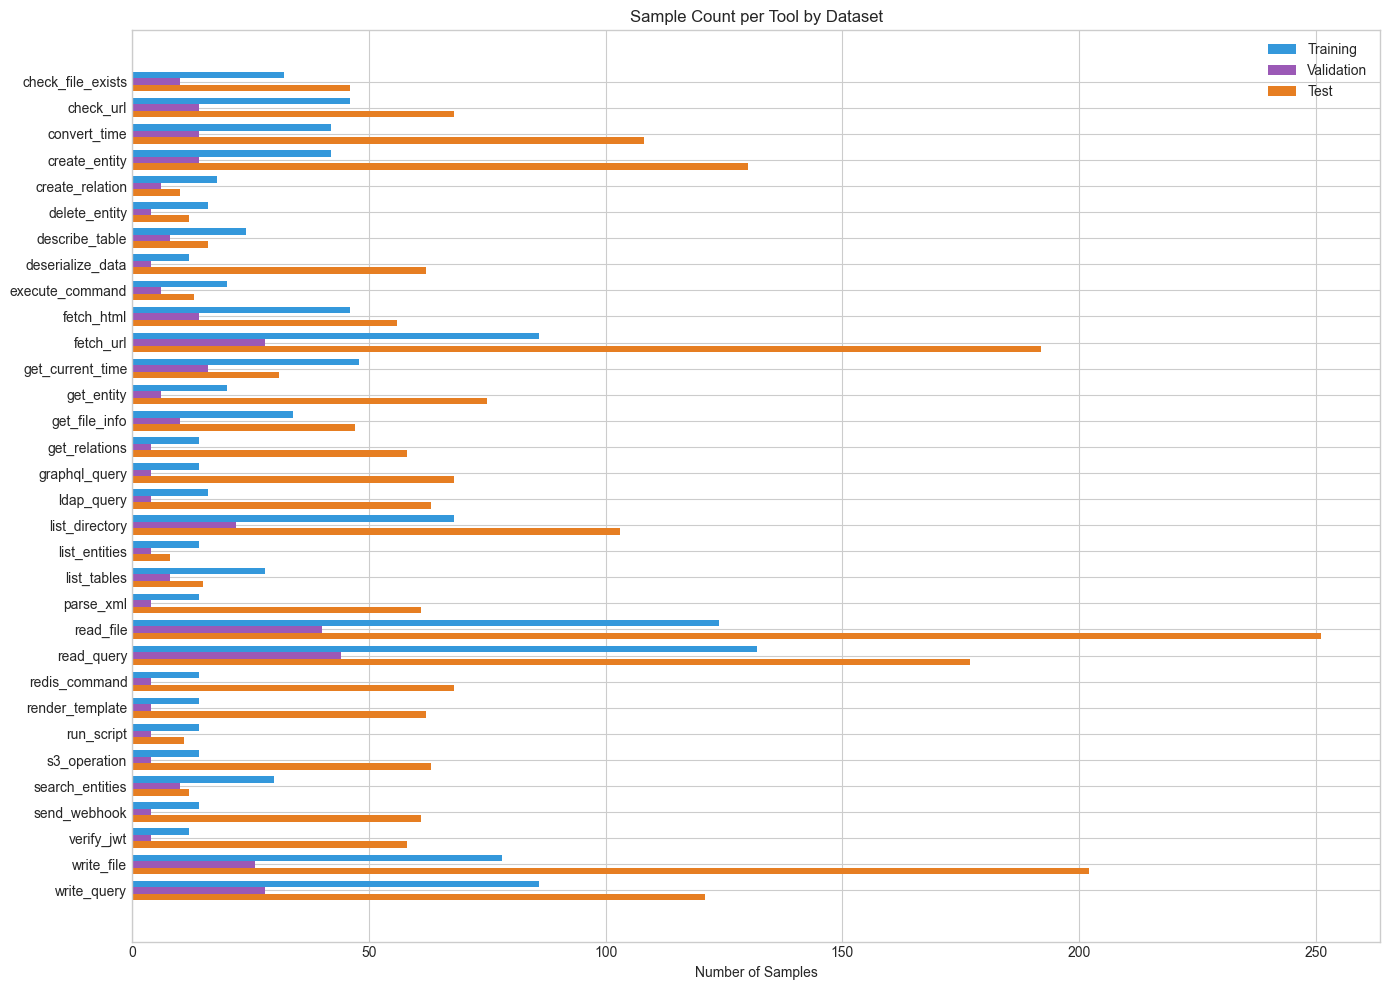

In [6]:
# Visualize per-tool distribution
fig, ax = plt.subplots(figsize=(14, 10))

tools = per_tool_df['Tool'].tolist()
x = np.arange(len(tools))
width = 0.25

train_totals = per_tool_df['Training_Total'].tolist()
val_totals = per_tool_df['Validation_Total'].tolist()
test_totals = per_tool_df['Test_Total'].tolist()

bars1 = ax.barh(x - width, train_totals, width, label='Training', color='#3498db')
bars2 = ax.barh(x, val_totals, width, label='Validation', color='#9b59b6')
bars3 = ax.barh(x + width, test_totals, width, label='Test', color='#e67e22')

ax.set_yticks(x)
ax.set_yticklabels(tools)
ax.set_xlabel('Number of Samples')
ax.set_title('Sample Count per Tool by Dataset')
ax.legend()
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../evaluation_results/owasp_per_tool_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Duplicate Detection (Within Datasets)

In [7]:
def find_duplicates_within(data: dict) -> dict:
    """Find duplicate samples within a dataset."""
    all_samples = []
    sample_locations = defaultdict(list)
    
    for tool, categories in data.items():
        for cat in ['benign', 'attack']:
            for sample in categories.get(cat, []):
                all_samples.append(sample)
                sample_locations[sample].append((tool, cat))
    
    # Find duplicates (samples appearing more than once)
    duplicates = {s: locs for s, locs in sample_locations.items() if len(locs) > 1}
    
    return {
        'total_samples': len(all_samples),
        'unique_samples': len(sample_locations),
        'duplicate_samples': len(duplicates),
        'duplicates': duplicates
    }

display(("### Duplicate Detection Within Each Dataset"))

dup_results = {}
for name, data in datasets.items():
    result = find_duplicates_within(data)
    dup_results[name] = result
    
    print(f"\n{name} Dataset:")
    print(f"  Total samples: {result['total_samples']}")
    print(f"  Unique samples: {result['unique_samples']}")
    print(f"  Duplicate samples: {result['duplicate_samples']}")
    
    if result['duplicates']:
        print(f"  \n  Duplicates found:")
        for sample, locs in list(result['duplicates'].items())[:5]:
            display_sample = sample[:60] + '...' if len(sample) > 60 else sample
            print(f"    - '{display_sample}' appears in: {locs}")
        if len(result['duplicates']) > 5:
            print(f"    ... and {len(result['duplicates']) - 5} more")

'### Duplicate Detection Within Each Dataset'


Training Dataset:
  Total samples: 1186
  Unique samples: 1122
  Duplicate samples: 48
  
  Duplicates found:
    - '{"path": "./README_v2_64.md"}' appears in: [('check_file_exists', 'benign'), ('get_file_info', 'benign')]
    - '{"path": "/proc/1/root/etc/passwd"}' appears in: [('check_file_exists', 'attack'), ('read_file', 'attack')]
    - '{"path": "../../../etc/passwd%00.jpg"}' appears in: [('check_file_exists', 'attack'), ('list_directory', 'attack'), ('write_file', 'attack')]
    - '{"path": "/var/run/secrets/kubernetes.io/serviceaccount/toke...' appears in: [('check_file_exists', 'attack'), ('read_file', 'attack')]
    - '{"path": ";/../../../etc/passwd"}' appears in: [('check_file_exists', 'attack'), ('list_directory', 'attack'), ('write_file', 'attack')]
    ... and 43 more

Validation Dataset:
  Total samples: 376
  Unique samples: 371
  Duplicate samples: 4
  
  Duplicates found:
    - '{"path": "README.md"}' appears in: [('check_file_exists', 'benign'), ('read_file', 'beni

## 5. Overlap Detection (Between Datasets)

In [8]:
def get_all_samples_full(data: dict) -> set:
    """Get all unique (tool, category, payload) tuples from a dataset."""
    samples = set()
    for tool, categories in data.items():
        for cat in ['benign', 'attack']:
            for payload in categories.get(cat, []):
                samples.add((tool, cat, payload))
    return samples

def get_all_samples_payload_only(data: dict) -> set:
    """Get all unique payload strings from a dataset (ignores tool/category)."""
    samples = set()
    for tool, categories in data.items():
        for cat in ['benign', 'attack']:
            samples.update(categories.get(cat, []))
    return samples

def find_overlaps(datasets: dict, full_match: bool = True) -> dict:
    """Find overlapping samples between datasets.
    
    Args:
        datasets: Dict of dataset name -> data
        full_match: If True, match on (tool, category, payload).
                    If False, match only on payload string.
    """
    if full_match:
        sample_sets = {name: get_all_samples_full(data) for name, data in datasets.items()}
    else:
        sample_sets = {name: get_all_samples_payload_only(data) for name, data in datasets.items()}
    
    overlaps = {}
    names = list(datasets.keys())
    
    for i, name1 in enumerate(names):
        for name2 in names[i+1:]:
            overlap = sample_sets[name1] & sample_sets[name2]
            overlaps[f"{name1}-{name2}"] = {
                'count': len(overlap),
                'samples': overlap
            }
    
    return overlaps

display(("### Overlap Detection Between Datasets (Full Match: tool+category+payload)"))

# Use full_match=True for (tool, category, payload) matching
overlaps = find_overlaps(datasets, full_match=True)

# Create overlap matrix
names = list(datasets.keys())
overlap_matrix = pd.DataFrame(0, index=names, columns=names)

for pair, data in overlaps.items():
    name1, name2 = pair.split('-')
    overlap_matrix.loc[name1, name2] = data['count']
    overlap_matrix.loc[name2, name1] = data['count']

# Fill diagonal with unique sample counts
for name, ds_data in datasets.items():
    overlap_matrix.loc[name, name] = len(get_all_samples_full(ds_data))

print("Overlap Matrix (diagonal = unique samples in dataset):")
display(overlap_matrix)

# Detail overlaps
print("\nDetailed Overlap Analysis:")
total_overlaps = 0
for pair, data in overlaps.items():
    print(f"\n  {pair}: {data['count']} overlapping samples")
    total_overlaps += data['count']
    if data['count'] > 0 and data['count'] <= 10:
        print("  Samples:")
        for item in data['samples']:
            tool, cat, payload = item
            display_payload = payload[:50] + '...' if len(payload) > 50 else payload
            print(f"    - [{tool}/{cat}] {display_payload}")
    elif data['count'] > 10:
        print(f"  First 5 samples:")
        for item in list(data['samples'])[:5]:
            tool, cat, payload = item
            display_payload = payload[:50] + '...' if len(payload) > 50 else payload
            print(f"    - [{tool}/{cat}] {display_payload}")

print(f"\n  TOTAL OVERLAPS: {total_overlaps}")
if total_overlaps == 0:
    print("  [PASS] No overlaps detected between any datasets!")
else:
    print("  [FAIL] Overlaps detected - datasets need regeneration!")

'### Overlap Detection Between Datasets (Full Match: tool+category+payload)'

Overlap Matrix (diagonal = unique samples in dataset):


,Training,Validation,Test
Training,1186,0,0
Validation,0,376,0
Test,0,0,2328



Detailed Overlap Analysis:

  Training-Validation: 0 overlapping samples

  Training-Test: 0 overlapping samples

  Validation-Test: 0 overlapping samples

  TOTAL OVERLAPS: 0
  [PASS] No overlaps detected between any datasets!


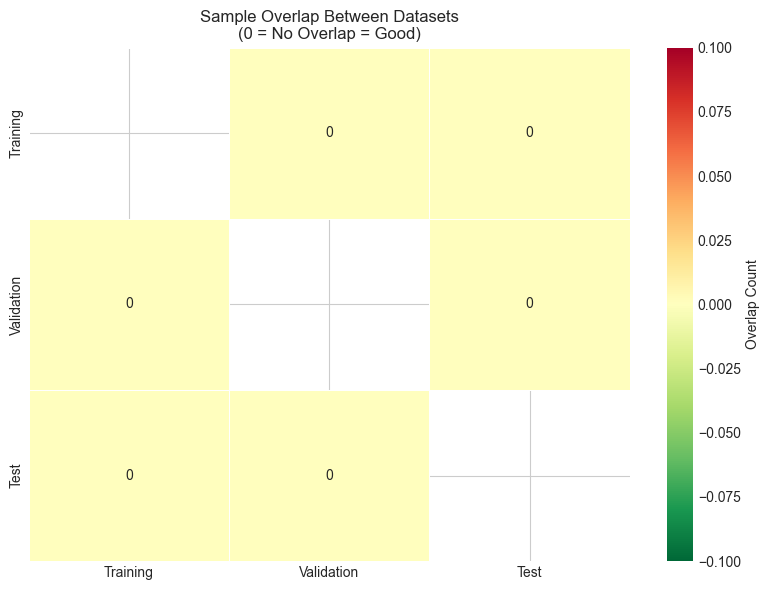

In [9]:
# Visualize overlaps with heatmap
fig, ax = plt.subplots(figsize=(8, 6))

# Create a modified matrix for visualization (exclude diagonal)
viz_matrix = overlap_matrix.copy()
for name in names:
    viz_matrix.loc[name, name] = np.nan

sns.heatmap(viz_matrix, annot=True, fmt='.0f', cmap='RdYlGn_r', 
            ax=ax, cbar_kws={'label': 'Overlap Count'},
            linewidths=0.5, linecolor='white')
ax.set_title('Sample Overlap Between Datasets\n(0 = No Overlap = Good)')

plt.tight_layout()
plt.savefig('../evaluation_results/owasp_overlap_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Attack Category Analysis

In [10]:
# Attack pattern detection
ATTACK_PATTERNS = {
    'Path Traversal': ['../', '..\\', '%2e%2e', '..../', '%c0%ae', '%252e'],
    'Command Injection': ['$(', '`', '&&', '; ', '|', '%0A', '${IFS}'],
    'SQL Injection': ["' OR", 'UNION', 'DROP', '--', '1=1', 'SELECT', 'INSERT', 'DELETE'],
    'XSS': ['<script', 'onerror', 'javascript:', '<img', 'alert('],
    'SSRF': ['localhost', '127.0.0.1', '169.254.169.254', '0x7f', 'gopher://', 'file://'],
    'XXE': ['<!ENTITY', '<!DOCTYPE', 'SYSTEM', 'file://'],
    'SSTI': ['{{', '${', '<%', '{%', '__class__', '__globals__'],
    'Deserialization': ['pickle', 'yaml', '!!python', 'rO0', 'O:8:'],
    'LDAP Injection': ['*)(', ')(cn=', 'objectClass=*'],
    'NoSQL Injection': ['$gt', '$ne', '$regex', '$where'],
    'JWT Attack': ['alg":"none', 'kid":', 'jwk":'],
}

def categorize_attacks(data: dict) -> Counter:
    """Categorize attack samples by pattern."""
    categories = Counter()
    
    for tool, cats in data.items():
        for sample in cats.get('attack', []):
            found = False
            for category, patterns in ATTACK_PATTERNS.items():
                if any(p.lower() in sample.lower() for p in patterns):
                    categories[category] += 1
                    found = True
                    break
            if not found:
                categories['Other'] += 1
    
    return categories

display(("### Attack Category Distribution"))

attack_cats = {}
for name, data in datasets.items():
    attack_cats[name] = categorize_attacks(data)
    
# Create DataFrame for comparison
all_categories = set()
for cats in attack_cats.values():
    all_categories.update(cats.keys())

cat_df = pd.DataFrame(index=sorted(all_categories))
for name, cats in attack_cats.items():
    cat_df[name] = pd.Series(cats)
cat_df = cat_df.fillna(0).astype(int)
cat_df['Total'] = cat_df.sum(axis=1)
cat_df = cat_df.sort_values('Total', ascending=False)

display(cat_df)

'### Attack Category Distribution'

,Training,Validation,Test,Total
Other,276,85,120,481
SQL Injection,94,29,29,152
Command Injection,86,29,33,148
SSRF,43,13,22,78
Path Traversal,42,16,15,73
SSTI,16,5,10,31
XXE,16,3,6,25
XSS,10,4,2,16
Deserialization,4,2,2,8
NoSQL Injection,4,1,0,5


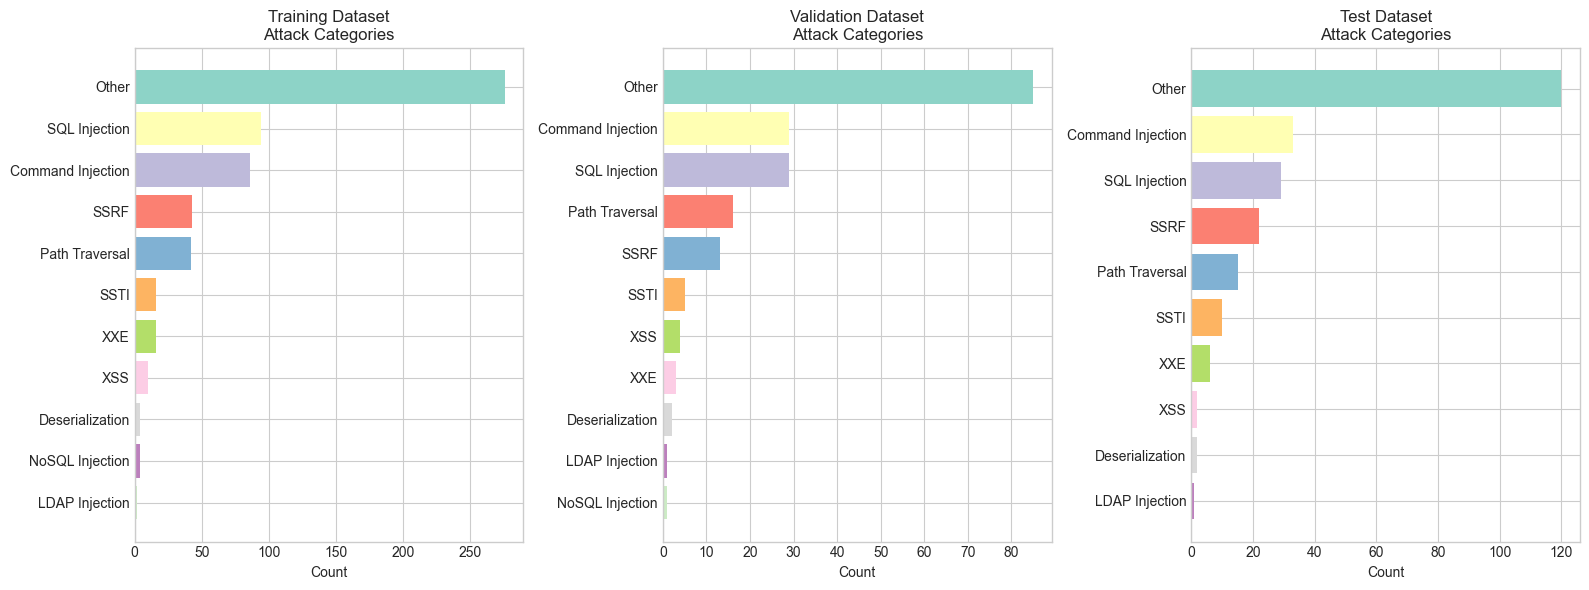

In [11]:
# Visualize attack categories
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

for idx, (name, cats) in enumerate(attack_cats.items()):
    if cats:
        sorted_cats = dict(sorted(cats.items(), key=lambda x: x[1], reverse=True))
        axes[idx].barh(list(sorted_cats.keys()), list(sorted_cats.values()), color=plt.cm.Set3.colors)
        axes[idx].set_xlabel('Count')
        axes[idx].set_title(f'{name} Dataset\nAttack Categories')
        axes[idx].invert_yaxis()

plt.tight_layout()
plt.savefig('../evaluation_results/owasp_attack_categories.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. OWASP Compliance Check

In [12]:
display(("### OWASP Ratio Compliance"))

# OWASP recommended ratios
OWASP_TARGETS = {
    'Training': {'benign': 50, 'attack': 50, 'tolerance': 5},
    'Validation': {'benign': 50, 'attack': 50, 'tolerance': 5},
    'Test': {'benign': 90, 'attack': 10, 'tolerance': 10},
}

compliance_rows = []
for name, data in datasets.items():
    stats = get_dataset_stats(data)
    target = OWASP_TARGETS[name]
    
    benign_diff = abs(stats['benign_pct'] - target['benign'])
    attack_diff = abs(stats['attack_pct'] - target['attack'])
    
    benign_pass = benign_diff <= target['tolerance']
    attack_pass = attack_diff <= target['tolerance']
    overall_pass = benign_pass and attack_pass
    
    compliance_rows.append({
        'Dataset': name,
        'Target Ratio': f"{target['benign']}/{target['attack']}",
        'Actual Ratio': f"{stats['benign_pct']:.1f}/{stats['attack_pct']:.1f}",
        'Benign Diff': f"{benign_diff:.1f}%",
        'Attack Diff': f"{attack_diff:.1f}%",
        'Tolerance': f"±{target['tolerance']}%",
        'Status': '✓ PASS' if overall_pass else '✗ FAIL'
    })

compliance_df = pd.DataFrame(compliance_rows)
display(compliance_df)

# Overall compliance
all_pass = all('PASS' in row['Status'] for row in compliance_rows)
if all_pass:
    print("\n[PASS] All datasets meet OWASP ratio requirements!")
else:
    print("\n[FAIL] Some datasets do not meet OWASP ratio requirements!")

'### OWASP Ratio Compliance'

,Dataset,Target Ratio,Actual Ratio,Benign Diff,Attack Diff,Tolerance,Status
0,Training,50/50,50.0/50.0,0.0%,0.0%,±5%,✓ PASS
1,Validation,50/50,50.0/50.0,0.0%,0.0%,±5%,✓ PASS
2,Test,90/10,89.7/10.3,0.3%,0.3%,±10%,✓ PASS



[PASS] All datasets meet OWASP ratio requirements!


## 8. Sample Length Analysis

'### Sample Length Distribution'

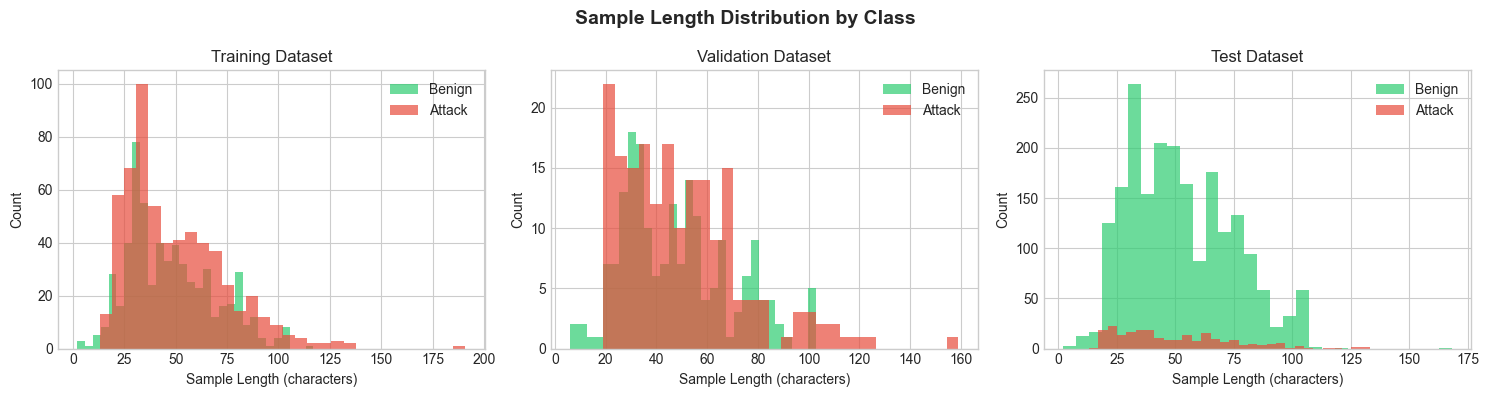

,Dataset,Benign Mean,Benign Std,Attack Mean,Attack Std
0,Training,47.7,21.2,49.6,24.4
1,Validation,48.4,21.3,49.7,24.4
2,Test,52.4,22.1,49.8,25.4


In [13]:
def get_sample_lengths(data: dict) -> dict:
    """Get sample length statistics."""
    benign_lengths = []
    attack_lengths = []
    
    for tool, categories in data.items():
        for sample in categories.get('benign', []):
            benign_lengths.append(len(sample))
        for sample in categories.get('attack', []):
            attack_lengths.append(len(sample))
    
    return {
        'benign': benign_lengths,
        'attack': attack_lengths
    }

display(("### Sample Length Distribution"))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, data) in enumerate(datasets.items()):
    lengths = get_sample_lengths(data)
    
    axes[idx].hist(lengths['benign'], bins=30, alpha=0.7, label='Benign', color='#2ecc71')
    axes[idx].hist(lengths['attack'], bins=30, alpha=0.7, label='Attack', color='#e74c3c')
    axes[idx].set_xlabel('Sample Length (characters)')
    axes[idx].set_ylabel('Count')
    axes[idx].set_title(f'{name} Dataset')
    axes[idx].legend()

plt.suptitle('Sample Length Distribution by Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../evaluation_results/owasp_sample_lengths.png', dpi=150, bbox_inches='tight')
plt.show()

# Length statistics table
length_stats = []
for name, data in datasets.items():
    lengths = get_sample_lengths(data)
    length_stats.append({
        'Dataset': name,
        'Benign Mean': np.mean(lengths['benign']) if lengths['benign'] else 0,
        'Benign Std': np.std(lengths['benign']) if lengths['benign'] else 0,
        'Attack Mean': np.mean(lengths['attack']) if lengths['attack'] else 0,
        'Attack Std': np.std(lengths['attack']) if lengths['attack'] else 0,
    })

length_df = pd.DataFrame(length_stats)
display(length_df.round(1))

## 9. Validation Summary Report

In [14]:
display(("## Validation Summary Report"))

# Calculate all checks
total_overlaps = sum(data['count'] for data in overlaps.values())
total_duplicates = sum(r['duplicate_samples'] for r in dup_results.values())
ratio_compliance = all('PASS' in row['Status'] for row in compliance_rows)

print("="*60)
print("OWASP DATASET VALIDATION REPORT")
print("="*60)
print()

# Dataset sizes
print("1. DATASET SIZES")
for name, data in datasets.items():
    stats = get_dataset_stats(data)
    print(f"   {name}: {stats['total_samples']} samples ({stats['tools']} tools)")
print()

# Class ratios
print("2. CLASS RATIOS (Benign/Attack)")
for name, data in datasets.items():
    stats = get_dataset_stats(data)
    target = OWASP_TARGETS[name]
    status = "PASS" if abs(stats['benign_pct'] - target['benign']) <= target['tolerance'] else "FAIL"
    print(f"   {name}: {stats['benign_pct']:.1f}/{stats['attack_pct']:.1f} (target: {target['benign']}/{target['attack']}) [{status}]")
print()

# Overlaps
print("3. DATASET OVERLAPS")
print(f"   Total overlapping samples: {total_overlaps}")
for pair, data in overlaps.items():
    print(f"   {pair}: {data['count']} overlaps")
overlap_status = "PASS" if total_overlaps == 0 else "FAIL"
print(f"   Status: [{overlap_status}]")
print()

# Duplicates
print("4. INTERNAL DUPLICATES")
print(f"   Total duplicate samples: {total_duplicates}")
for name, result in dup_results.items():
    print(f"   {name}: {result['duplicate_samples']} duplicates")
dup_status = "PASS" if total_duplicates == 0 else "WARN"
print(f"   Status: [{dup_status}]")
print()

# Overall
print("="*60)
overall_pass = total_overlaps == 0 and ratio_compliance
if overall_pass:
    print("OVERALL: [PASS] Datasets are valid and OWASP-compliant!")
else:
    print("OVERALL: [FAIL] Issues detected - see details above")
print("="*60)

'## Validation Summary Report'

OWASP DATASET VALIDATION REPORT

1. DATASET SIZES
   Training: 1186 samples (32 tools)
   Validation: 376 samples (32 tools)
   Test: 2328 samples (32 tools)

2. CLASS RATIOS (Benign/Attack)
   Training: 50.0/50.0 (target: 50/50) [PASS]
   Validation: 50.0/50.0 (target: 50/50) [PASS]
   Test: 89.7/10.3 (target: 90/10) [PASS]

3. DATASET OVERLAPS
   Total overlapping samples: 0
   Training-Validation: 0 overlaps
   Training-Test: 0 overlaps
   Validation-Test: 0 overlaps
   Status: [PASS]

4. INTERNAL DUPLICATES
   Total duplicate samples: 79
   Training: 48 duplicates
   Validation: 4 duplicates
   Test: 27 duplicates
   Status: [WARN]

OVERALL: [PASS] Datasets are valid and OWASP-compliant!


In [15]:
# Export summary to CSV
summary_data = {
    'Metric': [
        'Training Samples', 'Validation Samples', 'Test Samples',
        'Training Ratio (B/A)', 'Validation Ratio (B/A)', 'Test Ratio (B/A)',
        'Train-Val Overlaps', 'Train-Test Overlaps', 'Val-Test Overlaps',
        'Total Duplicates', 'OWASP Compliant'
    ],
    'Value': [
        get_dataset_stats(train_data)['total_samples'],
        get_dataset_stats(val_data)['total_samples'],
        get_dataset_stats(test_data)['total_samples'],
        f"{get_dataset_stats(train_data)['benign_pct']:.1f}/{get_dataset_stats(train_data)['attack_pct']:.1f}",
        f"{get_dataset_stats(val_data)['benign_pct']:.1f}/{get_dataset_stats(val_data)['attack_pct']:.1f}",
        f"{get_dataset_stats(test_data)['benign_pct']:.1f}/{get_dataset_stats(test_data)['attack_pct']:.1f}",
        overlaps['Training-Validation']['count'],
        overlaps['Training-Test']['count'],
        overlaps['Validation-Test']['count'],
        total_duplicates,
        'Yes' if overall_pass else 'No'
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('../evaluation_results/owasp_validation_summary.csv', index=False)
print("Summary exported to: ../evaluation_results/owasp_validation_summary.csv")

# Export per-tool stats
per_tool_df.to_csv('../evaluation_results/owasp_per_tool_stats.csv', index=False)
print("Per-tool stats exported to: ../evaluation_results/owasp_per_tool_stats.csv")

# Export attack categories
cat_df.to_csv('../evaluation_results/owasp_attack_categories.csv')
print("Attack categories exported to: ../evaluation_results/owasp_attack_categories.csv")

Summary exported to: ../evaluation_results/owasp_validation_summary.csv
Per-tool stats exported to: ../evaluation_results/owasp_per_tool_stats.csv
Attack categories exported to: ../evaluation_results/owasp_attack_categories.csv


## 10. Detailed Overlap Report (if any)

In [16]:
if total_overlaps > 0:
    display(("### Detailed Overlap Report (Full Match: tool+category+payload)"))
    
    all_overlapping = []
    for pair, data in overlaps.items():
        for item in data['samples']:
            tool, cat, payload = item
            all_overlapping.append({
                'Dataset Pair': pair,
                'Tool': tool,
                'Category': cat,
                'Payload': payload[:100] + '...' if len(payload) > 100 else payload,
                'Length': len(payload)
            })
    
    if all_overlapping:
        overlap_df = pd.DataFrame(all_overlapping)
        display(overlap_df)
        
        # Export to file
        overlap_df.to_csv('../evaluation_results/owasp_overlapping_samples.csv', index=False)
        print(f"\nExported {len(all_overlapping)} overlapping samples to: ../evaluation_results/owasp_overlapping_samples.csv")
else:
    print("No overlaps to report - datasets are clean!")

No overlaps to report - datasets are clean!
